# Preprocessing

### Dataset
- Dataset source: https://www.data.gov.uk/dataset/ff93ffc1-6656-47d8-9155-85ea0b8f2251/national-public-transport-access-nodes-naptan
- Last Updated in 23 August 2022 by the Department for Transport

### Methodology
- Using Schneiderman's Mantra to approach the Visual Analytics Process

## 1. Overview of Data

In [18]:
!pip install pyproj

   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
    --------------------------------------- 0.1/6.2 MB 2.6 MB/s eta 0:00:03
   ---- ----------------------------------- 0.7/6.2 MB 8.7 MB/s eta 0:00:01
   ------------- -------------------------- 2.1/6.2 MB 18.9 MB/s eta 0:00:01
   ------------- -------------------------- 2.1/6.2 MB 18.9 MB/s eta 0:00:01
   -------------------- ------------------- 3.1/6.2 MB 16.7 MB/s eta 0:00:01
   ----------------------- ---------------- 3.6/6.2 MB 13.6 MB/s eta 0:00:01
   ---------------------------------------  6.2/6.2 MB 20.9 MB/s eta 0:00:01
   ---------------------------------------- 6.2/6.2 MB 19.9 MB/s eta 0:00:00


In [51]:
!pip install geopy

   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   ---------------------------------------  122.9/125.4 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 125.4/125.4 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
   ---------------------------------------- 40.3/40.3 kB 1.9 MB/s eta 0:00:00


In [136]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Proj, transform # 2nd iteration
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

In [106]:
# An overview of the NaPTAN dataset
stops_data = pd.read_csv('../data/raw/stops.csv', low_memory = False)
stops_data.info()
stops_data.describe()
stops_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435046 entries, 0 to 435045
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ATCOCode                 435046 non-null  object 
 1   NaptanCode               409329 non-null  object 
 2   PlateCode                62938 non-null   object 
 3   CleardownCode            0 non-null       float64
 4   CommonName               435046 non-null  object 
 5   CommonNameLang           0 non-null       float64
 6   ShortCommonName          96644 non-null   object 
 7   ShortCommonNameLang      0 non-null       float64
 8   Landmark                 251191 non-null  object 
 9   LandmarkLang             0 non-null       float64
 10  Street                   411203 non-null  object 
 11  StreetLang               0 non-null       float64
 12  Crossing                 0 non-null       float64
 13  CrossingLang             0 non-null       float64
 14  Indi

,ATCOCode,NaptanCode,PlateCode,CleardownCode,CommonName,CommonNameLang,ShortCommonName,ShortCommonNameLang,Landmark,LandmarkLang,...,TimingStatus,DefaultWaitTime,Notes,NotesLang,AdministrativeAreaCode,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Status
0,0100BRP90310,bstgwpa,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2023-04-21T18:02:19,99.0,new,active
1,0100BRP90311,bstgwpm,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2019-09-13T10:41:38,73.0,new,active
2,10000056,bstpjgw,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2019-08-06T00:00:00,2019-08-06T11:09:11,120.0,new,active
3,0100BRP90312,bstjaja,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2020-11-26T13:23:29,45.0,new,active
4,0100BRP90313,bstjama,NaN,NaN,Temple Meads Stn,NaN,Temple Meads Stn,NaN,NaN,NaN,...,OTH,NaN,NaN,NaN,9,2009-08-25T00:00:00,2020-11-26T13:22:13,44.0,new,active


## 2. Zoom and Filter (And using Overview at the end of stages)

#### a. Handling Missing and Conflicting Values (1st iteration)

##### The "Modification" and "Status" columns
- I want to define rules to handle the rows that have the values: delete, inactive and pending. I'm doing this because the dataset should represent active stops.
- I will keep the rows with the "pending" value but treat this as a potential limitation, because of the maintenance records. This might change depending on the results.

In [107]:
# Dropping the rows with 'delete' and 'inactive' string values
stops_data = stops_data[~((stops_data['Modification'] == 'delete') & (stops_data['Status'] == 'inactive'))]

# Check the number of rows removed
initial_minus_first_column = 435045
print(f"Rows removed: {initial_minus_first_column - stops_data.shape[0]}")

Rows removed: 17935


In [108]:
# Displaying the ratio of missing values in features (0 for no missing values)
missing_ratio = stops_data.isnull().mean()
print(missing_ratio.sort_values(ascending = False))

DefaultWaitTime            1.000000
Notes                      1.000000
IndicatorLang              1.000000
CrossingLang               1.000000
Crossing                   1.000000
StreetLang                 1.000000
LandmarkLang               1.000000
GrandParentLocalityName    1.000000
ShortCommonNameLang        1.000000
CommonNameLang             1.000000
NotesLang                  1.000000
CleardownCode              1.000000
SuburbLang                 0.972952
TownLang                   0.964678
PlateCode                  0.849222
Suburb                     0.829594
ShortCommonName            0.772012
Town                       0.638520
ParentLocalityName         0.563698
Landmark                   0.414246
Latitude                   0.125600
Longitude                  0.125600
Modification               0.084695
Indicator                  0.055501
Street                     0.054997
Bearing                    0.053240
NaptanCode                 0.046932
BusStopType                0

##### The "LocalityCentre" column (1st iteration)
- This column of an object data type has mixed values (i.e. TRUE, FALSE, 1, 0)
- These columns need to be consistent (i.e. True, False).

In [109]:
stops_data['LocalityCentre'] = stops_data['LocalityCentre'].map({'TRUE' : True, '1' : True, 'FALSE' : False, 
                                                                 '0' : False})

**2nd ITERATION - The "LocalityCentre" column**
- Converting the column now 
- Using the astype() method to change this column to a bool as they now contain consistent **True** and **False** values.
- This is good for the logical aspects of analysis and to make it easier for human reasoning.
- Source: https://www.w3schools.com/python/pandas/ref_df_astype.asp

In [110]:
stops_data['LocalityCentre'] = stops_data['LocalityCentre'].astype('bool')

##### Missing Geographical Data (1st iteration)
- Identify the rows with the missing geospatial data
- Then separate the missing geospatial data for analysis (It may be useful later, or if we having an imputation solution)

In [111]:
# Checking how many rows with missing geospatial data
missing_geo_data = stops_data[stops_data['Longitude'].isna() | 
stops_data['Latitude'].isna()]
print(f"Rows with missing geospatial data: {missing_geo_data.shape[0]}")

# Separate geospatial data for analysis
stops_data = stops_data.dropna(subset = ['Longitude', 'Latitude'])
stops_data_without_geo = stops_data[stops_data['Longitude'].isna() & stops_data['Latitude'].isna()]

Rows with missing geospatial data: 52389


##### General Missing Values (1st Iteration)
- So far, 52389 rows have been removed due to missing geospatial data. Time to look at the columns.
- There are lot of missing values in the columns. Some of them are understandable but I want to get a clearer picture of which columns to remove
- I will remove the columns whose values are missing by 40% to 60%. 

In [112]:
# Displaying the ratio of missing values in features (0 for no missing values)
missing_ratio = stops_data.isnull().mean()
print(missing_ratio.sort_values(ascending = False))

StreetLang                 1.000000
IndicatorLang              1.000000
CleardownCode              1.000000
DefaultWaitTime            1.000000
CommonNameLang             1.000000
GrandParentLocalityName    1.000000
ShortCommonNameLang        1.000000
LandmarkLang               1.000000
NotesLang                  1.000000
Crossing                   1.000000
CrossingLang               1.000000
Notes                      1.000000
SuburbLang                 0.969067
TownLang                   0.959605
PlateCode                  0.827570
Suburb                     0.817115
ShortCommonName            0.753516
Town                       0.691452
ParentLocalityName         0.566562
Landmark                   0.421580
Street                     0.062393
Indicator                  0.060279
Bearing                    0.056490
NaptanCode                 0.050809
BusStopType                0.043976
Modification               0.042698
TimingStatus               0.037774
RevisionNumber             0

**2nd Iteration - Missing Geographical Data**
- I realised further down the preprocessing stage, that there are no missing values for "Northing" and "Easting" features. Therefore using the pyproj python library, I can convert the coordinate systems.
- Therefore, 52389 rows have been restored and their Northing/Easting values converted to produce Longitude/Latitude values.
- Source https://pyproj4.github.io/pyproj/stable/api/transformer.html

In [113]:
# Adding back the rows with the missing geographical data (Longitude and Latitude)
stops_data = pd.concat([stops_data, stops_data_without_geo])

# Converting the Easting and Northing to Longitude and Latitude
# Defining the Ordinance Survey National Grid projection for Easting/Northing
osgb36 = Proj('epsg:27700') # For Easting/Northing
wsg84 = Proj('epsg:4326') # For Latitude/Longitude

# Creating a function to convert Easting/Northing to Lat/Long
def convert_to_lon_lat(row):
    if pd.notnull(row['Easting']) and pd.notnull(row['Northing']):
        lon, lat = transform(osgb36, wsg84, row['Easting'], row['Northing'])
        return pd.Series({'Longitude': lon, 'Latitude': lat})
    return pd.Series({'Longitude': None, 'Latitude': None})

# Applying the conversion to the rows with missing geographic data
missing_geo_data_converted = stops_data[stops_data['Longitude'].isna() | stops_data['Latitude'].isna()]
converted_coordinates = missing_geo_data_converted.apply(convert_to_lon_lat, axis = 1)

# Updating the rows with converted Longitude and Latitude
stops_data.loc[missing_geo_data_converted.index, ['Longitude', 'Latitude']] = converted_coordinates

# Checking if all missing geo data is filled or not
missing_geo_data_updated = stops_data[stops_data['Longitude'].isna() | stops_data['Latitude'].isna()]
print(f"Rows with missing geospatial data after conversion: {missing_geo_data_updated.shape[0]}")

Rows with missing geospatial data after conversion: 0


In [114]:
# Displaying the ratio of missing values in features (0 for no missing values)
missing_ratio = stops_data.isnull().mean()
print(missing_ratio.sort_values(ascending = False))

StreetLang                 1.000000
IndicatorLang              1.000000
CleardownCode              1.000000
DefaultWaitTime            1.000000
CommonNameLang             1.000000
GrandParentLocalityName    1.000000
ShortCommonNameLang        1.000000
LandmarkLang               1.000000
NotesLang                  1.000000
Crossing                   1.000000
CrossingLang               1.000000
Notes                      1.000000
SuburbLang                 0.969067
TownLang                   0.959605
PlateCode                  0.827570
Suburb                     0.817115
ShortCommonName            0.753516
Town                       0.691452
ParentLocalityName         0.566562
Landmark                   0.421580
Street                     0.062393
Indicator                  0.060279
Bearing                    0.056490
NaptanCode                 0.050809
BusStopType                0.043976
Modification               0.042698
TimingStatus               0.037774
RevisionNumber             0

- Therefore, there are 20 columns to remove. They are not critical for analysis in regards to the research question about rural vs urban.

In [115]:
# Calculating the percentages of missing values per column
missing_percent = stops_data.isnull().mean() * 100

# Displaying the column with missing values
missing_percent_final = missing_percent.sort_values(ascending = False)

# The threshold for removal is set to 40% missing data
columns_to_drop = missing_percent_final[missing_percent_final > 40].index

# Removing the columns
stops_data = stops_data.drop(columns = columns_to_drop)

# Displaying the removal and what columns remain
print(f"Count of columns removed who had >40% missing values: {list(columns_to_drop)}")
print(f"Columns remaining: {stops_data.columns}")
print(f"Rows and Columns remaining: {stops_data.shape}")


missing_ratio = stops_data.isnull().mean()
print(missing_ratio.sort_values(ascending = False))

Count of columns removed who had >40% missing values: ['StreetLang', 'IndicatorLang', 'CleardownCode', 'DefaultWaitTime', 'CommonNameLang', 'GrandParentLocalityName', 'ShortCommonNameLang', 'LandmarkLang', 'NotesLang', 'Crossing', 'CrossingLang', 'Notes', 'SuburbLang', 'TownLang', 'PlateCode', 'Suburb', 'ShortCommonName', 'Town', 'ParentLocalityName', 'Landmark']
Columns remaining: Index(['ATCOCode', 'NaptanCode', 'CommonName', 'Street', 'Indicator',
       'Bearing', 'NptgLocalityCode', 'LocalityName', 'LocalityCentre',
       'GridType', 'Easting', 'Northing', 'Longitude', 'Latitude', 'StopType',
       'BusStopType', 'TimingStatus', 'AdministrativeAreaCode',
       'CreationDateTime', 'ModificationDateTime', 'RevisionNumber',
       'Modification', 'Status'],
      dtype='object')
Rows and Columns remaining: (364721, 23)
Street                    0.062393
Indicator                 0.060279
Bearing                   0.056490
NaptanCode                0.050809
BusStopType             

- After removing the columns with more than 40% missing values and separating 52389 rows of missing geospatial data, the current column with the highest missing values is the "Street" column with 6.2%. This is very low, and a positive result.


In [116]:
stops_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364721 entries, 0 to 435045
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ATCOCode                364721 non-null  object 
 1   NaptanCode              346190 non-null  object 
 2   CommonName              364721 non-null  object 
 3   Street                  341965 non-null  object 
 4   Indicator               342736 non-null  object 
 5   Bearing                 344118 non-null  object 
 6   NptgLocalityCode        364721 non-null  object 
 7   LocalityName            364721 non-null  object 
 8   LocalityCentre          364721 non-null  bool   
 9   GridType                362845 non-null  object 
 10  Easting                 364721 non-null  int64  
 11  Northing                364721 non-null  int64  
 12  Longitude               364721 non-null  float64
 13  Latitude                364721 non-null  float64
 14  StopType            

In [117]:
stops_data.head()

,ATCOCode,NaptanCode,CommonName,Street,Indicator,Bearing,NptgLocalityCode,LocalityName,LocalityCentre,GridType,...,Latitude,StopType,BusStopType,TimingStatus,AdministrativeAreaCode,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Status
0,0100BRP90310,bstgwpa,Temple Meads Stn,Redcliffe Way,T3,E,N0077020,Temple Meads,False,UKOS,...,51.44902,BCT,MKD,OTH,9,2009-08-25T00:00:00,2023-04-21T18:02:19,99.0,new,active
1,0100BRP90311,bstgwpm,Temple Meads Stn,Victoria Street,T7,NW,N0077020,Temple Meads,False,UKOS,...,51.45014,BCT,MKD,OTH,9,2009-08-25T00:00:00,2019-09-13T10:41:38,73.0,new,active
2,10000056,bstpjgw,Temple Meads Stn,Temple Gate,T2,N,N0077020,Temple Meads,False,UKOS,...,51.44967,BCT,MKD,OTH,9,2019-08-06T00:00:00,2019-08-06T11:09:11,120.0,new,active
3,0100BRP90312,bstjaja,Temple Meads Stn,Station Approach,T6,NE,N0077020,Temple Meads,False,UKOS,...,51.44898,BCT,MKD,OTH,9,2009-08-25T00:00:00,2020-11-26T13:23:29,45.0,new,active
4,0100BRP90313,bstjama,Temple Meads Stn,Station Approach,T5,NE,N0077020,Temple Meads,False,UKOS,...,51.44944,BCT,MKD,OTH,9,2009-08-25T00:00:00,2020-11-26T13:22:13,44.0,new,active


**2nd Iteration**
I want to check display some of the rows where RevisionNumber is NaN. I want to see if there are any patterns

In [118]:
missing_revision_rows = stops_data[stops_data['RevisionNumber'].isnull()]
print(f"Number of rows with missing RevisionNumber: {len(missing_revision_rows)}")
missing_revision_rows

Number of rows with missing RevisionNumber: 5513


,ATCOCode,NaptanCode,CommonName,Street,Indicator,Bearing,NptgLocalityCode,LocalityName,LocalityCentre,GridType,...,Latitude,StopType,BusStopType,TimingStatus,AdministrativeAreaCode,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Status
32799,0690WNA02952,wrgmpmg,Penketh High School,Heath Road,o/s,E,E0053808,Penketh,True,NaN,...,53.387517,BCT,MKD,OTH,63,2019-04-08T11:27:29,2019-04-08T11:19:38,NaN,new,active
32800,0690WNA02953,wrgmpmj,Warrington Vale Royal College,Long Lane,Entance,NaN,E0043038,Orford,True,NaN,...,53.407577,BCE,NaN,NaN,63,2019-04-08T11:40:53,2019-04-08T11:33:38,NaN,new,active
32801,0690WNA02954,wrgmpmp,Hinton House,Birchwood Park Avenue,O/S,S,E0053799,Birchwood,True,NaN,...,53.427001,BCT,MKD,OTH,63,2019-11-26T13:44:15,2019-11-26T13:39:23,NaN,new,active
32808,0690WNA02961,wrgmpwp,ASDA Omega,Omega Boulevard,o\s,W,E0053805,Great Sankey,True,NaN,...,53.413731,BCT,MKD,OTH,63,2020-03-20T10:35:45,2020-03-20T10:32:29,NaN,new,active
32809,0690WNA02962,wrgmtad,Plastic Omnium,Orion Boulevard,o\s,E,E0053805,Great Sankey,True,NaN,...,53.407256,BCT,MKD,OTH,63,2020-03-20T10:57:12,2020-03-20T10:50:39,NaN,new,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376941,5810WDB48133,swatpdg,Crwys Terrace,Heol Cadifor,opp number 4,W,E0042367,Penlan,True,NaN,...,51.654729,BCT,MKD,OTH,56,2024-11-04T11:13:59,2024-11-04T11:11:45,NaN,new,active
378256,5820WDB48460,nptmapg,Margam Crematorium,NaN,Car Park,N,E0054426,Margam,True,NaN,...,51.556526,BCT,CUS,PPT,34,2024-05-02T11:32:53,2024-05-02T11:13:56,NaN,new,active
378258,5820WDB48462,nptmamp,Crymlyn Parc,NaN,NaN,N,E0054418,Coedffranc,True,NaN,...,51.655420,BCT,MKD,OTH,34,2024-05-02T14:26:07,2024-05-02T14:23:59,NaN,new,active
378259,5820WDB48463,nptmamt,Crymlyn Road,NaN,NaN,SW,E0054418,Coedffranc,True,NaN,...,51.655829,BCT,MKD,OTH,34,2024-05-02T14:32:31,2024-05-02T14:31:16,NaN,new,active


I can see from the sample above, that when "RevisionNumber" is NaN, then the "Modification" value is 'new'. I want to check if this is coincidental or not. If it is not coincidental, then this means that "RevisionNumber" should be set to zero. This would confirm whether new modifications are considered to be a revised or not yet revised. Also, keeping in mind that "Modification" has some missing values as well.

**2nd Iteration**
I just realised that the where the "RevisionNumber" is NaN, the "CreationDateTime" and "ModificationDateTime" are the same days of the year, given that the "RevisionNumber" > 0.

In [119]:
# Checking if all missing RevisionNumber rows have Modification values equal to 'new', then if find the percentage if not
valid_rows = missing_revision_rows['Modification'].notna()
total_valid_rows = valid_rows.sum()
all_new_modifications = missing_revision_rows.loc[valid_rows, 'Modification'].eq('new').all()
new_modification_count = missing_revision_rows.loc[valid_rows, 'Modification'].eq('new').sum()

if all_new_modifications:
    print("All rows with missing RevisionNumber have 'Modification' equal to 'new'.")
else:
    print("Not all rows with missing RevisionNumber have 'Modification' to 'new'.")

# Calculating the percentage
new_percentage = (new_modification_count / total_valid_rows) * 100

print(f"Percentage of rows with missing RevisionNumber and Modification set to 'new' (excluding NaN): {new_percentage}%")          

Not all rows with missing RevisionNumber have 'Modification' to 'new'.
Percentage of rows with missing RevisionNumber and Modification set to 'new' (excluding NaN): 9.595501541810266%


This result shows that this was a coincidence and missing RevisionNumbers do not all have "Modification" values equal to 'new'. I need to do a missing value analysis and decide what to do with those columns, in regards to the new research questions below.

#### **"2nd Iteration** - Missing value analysis

Missing Value Analysis:
Street            6.239290
Indicator         6.027895
Bearing           5.648976
NaptanCode        5.080870
BusStopType       4.397608
Modification      4.269839
TimingStatus      3.777408
RevisionNumber    1.511566
GridType          0.514366
dtype: float64


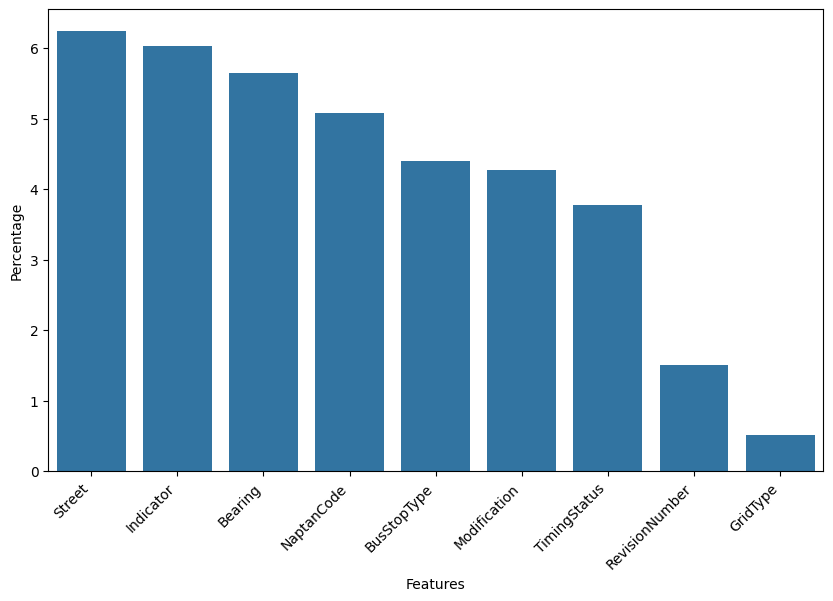

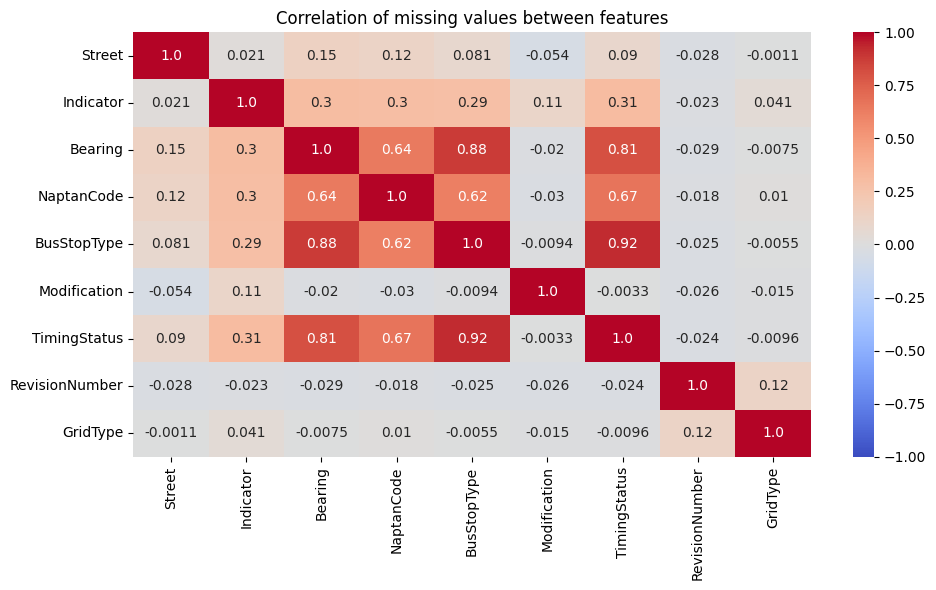

                  Street  Indicator   Bearing  NaptanCode  BusStopType  \
Street          1.000000   0.021304  0.147627    0.123257     0.081452   
Indicator       0.021304   1.000000  0.298404    0.295546     0.285089   
Bearing         0.147627   0.298404  1.000000    0.641451     0.876521   
NaptanCode      0.123257   0.295546  0.641451    1.000000     0.617923   
BusStopType     0.081452   0.285089  0.876521    0.617923     1.000000   
Modification   -0.054480   0.109361 -0.019838   -0.030213    -0.009447   
TimingStatus    0.089690   0.311587  0.809742    0.668234     0.923814   
RevisionNumber -0.027684  -0.022785 -0.028951   -0.017816    -0.025255   
GridType       -0.001117   0.040891 -0.007467    0.010417    -0.005514   

                Modification  TimingStatus  RevisionNumber  GridType  
Street             -0.054480      0.089690       -0.027684 -0.001117  
Indicator           0.109361      0.311587       -0.022785  0.040891  
Bearing            -0.019838      0.809742    

In [120]:
# Calculating the percentage of missing values
missing_values = stops_data.isnull().mean() * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)

# Displaying missing value percentages
print("Missing Value Analysis:")
print(missing_values)

# Visualising the missing values
plt.figure(figsize = (10, 6))
sns.barplot(x = missing_values.index, y = missing_values.values)
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel("Percentage")
plt.xlabel("Features")
plt.show()

# Pairwise correlation for features with missing values
missing_features = missing_values.index
correlation_matrix = stops_data[missing_features].isnull().corr()

# Visualising the correlation of columns with missing values
plt.figure(figsize = (10, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2", vmin = -1, vmax = 1)
plt.title("Correlation of missing values between features")
plt.tight_layout()
plt.savefig("../outputs/missing_values_correlation_heatmap.png")
plt.show()

print(correlation_matrix)

#### Decisions from the Heatmap results
Based on findings from: https://www.gov.uk/government/publications/national-public-transport-access-node-schema/naptan-guide-for-data-managers
1. Street: An API would be needed for accurate imputation and the values are specific.
2. GridType: This is more of a reference to the geographic data or features, therefore, this will be dropped.
3. NaPTANCode: This is an unique identifier for tracking stops. The missing values cannot be filled with imputation or modification. However, every bus stop should have a NaPTAN code. I will removed the rows that do not have this, and see the different.
4. BusStopType: KNN may be a good approach, as it is relevant for the first research question below. I will apply **Label Encoding** beforehand, because the categories are not ordinal. **2nd iteration** - I will use Iterative Imputation for this due KNN Imputation leaving some missing values.
5. Modification: This is vital for the second research question below, so it has to be kept.
6. TimingStatus: **2nd iteration** - I will use Iterative Imputation for this, with the remaining BusStopType missing values. 
7. RevisionNumber: I think that KNN imputation is not acceptable because correlations are low. I will put zero as a replacement to be safe, assuming that no revision has been done.
8. Bearing: This is the direction that the vehicle would be facing at the bus stop. I will remove this column because it does not relate to the research questions
9. Indicator: This is another one which is not needed. So I will drop this.

In [121]:
# Storing the original number of rows
original_rows = stops_data.shape[0]

# Drop the rows with the missing NaPTAN Codes, as every bus stop should have it
stops_data = stops_data.dropna(subset = ['NaptanCode'])

# Label encoding for BusStopType to do KNN Imputation
label_encoder = LabelEncoder()
stops_data['BusStopType_encoded'] = label_encoder.fit_transform(stops_data['BusStopType'])

# Imputing missing BusStopType with KNN, due to high correlations results with BusStopType and other feature missing values
# 5 Nearest Neighbours will be used to be on the safe side.
knn_imputer = KNNImputer(n_neighbors = 5)
stops_data['BusStopType_encoded'] = knn_imputer.fit_transform(stops_data[['BusStopType_encoded']])

# Converting the imputed values to integer data types before inverse transformation
stops_data['BusStopType_encoded'] = stops_data['BusStopType_encoded'].astype(int)

# Mapping the encoded values back to the original categories
stops_data['BusStopType'] = label_encoder.inverse_transform(stops_data['BusStopType_encoded'])

# Dropping the encoded column
stops_data = stops_data.drop(columns = ['BusStopType_encoded'])

# Replacing missing RevisionNumber with zero
stops_data['RevisionNumber'] = stops_data['RevisionNumber'].fillna(0)

# Calculating and displaying the number of rows dropped
dropped_rows = original_rows - stops_data.shape[0]
print(f"Number of rows dropped due to missing NaPTANCode: {dropped_rows}")

# Checking the results after processing
missing_values_after = stops_data.isnull().mean() * 100
print("Missing Values After Processing:")
print(missing_values_after)

Number of rows dropped due to missing NaPTANCode: 18531
Missing Values After Processing:
ATCOCode                  0.000000
NaptanCode                0.000000
CommonName                0.000000
Street                    5.549554
Indicator                 4.400474
Bearing                   2.222768
NptgLocalityCode          0.000000
LocalityName              0.000000
LocalityCentre            0.000000
GridType                  0.497126
Easting                   0.000000
Northing                  0.000000
Longitude                 0.000000
Latitude                  0.000000
StopType                  0.000000
BusStopType               1.466247
TimingStatus              0.829891
AdministrativeAreaCode    0.000000
CreationDateTime          0.000000
ModificationDateTime      0.000000
RevisionNumber            0.000000
Modification              4.411162
Status                    0.000000
dtype: float64


Some of the "BusStopType" were not imputed, which could be because of the number of features or lack of relationships found. I will use a more sophisticated method, such as Iterative Imputation, but also include the "TimingStatus" column.

In [122]:
# Imputing the missing values in categorical columns using SimpleImputer
simple_imputer = SimpleImputer(strategy = 'most_frequent')  # Imputing with the most frequent category
stops_data[['BusStopType', 'TimingStatus']] = simple_imputer.fit_transform(stops_data[['BusStopType', 'TimingStatus']])

# Label encoding the categorical columns after imputation
label_encoder = LabelEncoder()
stops_data['BusStopType_encoded'] = label_encoder.fit_transform(stops_data['BusStopType'])
stops_data['TimingStatus_encoded'] = label_encoder.fit_transform(stops_data['TimingStatus'])

# Applying IterativeImputer to the numerical columns.
iterative_imputer = IterativeImputer(max_iter = 10, random_state = 1)
# Applying IterativeImputer only to the numerical columns.
stops_data[['BusStopType_encoded', 'TimingStatus_encoded']] = iterative_imputer.fit_transform(stops_data[['BusStopType_encoded', 'TimingStatus_encoded']])

# Converting the imputed float values to integers before inverse transformation
stops_data['BusStopType_encoded'] = stops_data['BusStopType_encoded'].round().astype(int)
stops_data['TimingStatus_encoded'] = stops_data['TimingStatus_encoded'].round().astype(int)

# Inverse transforming the encoded values back to the original categories
stops_data['BusStopType'] = label_encoder.inverse_transform(stops_data['BusStopType_encoded'])
stops_data['TimingStatus'] = label_encoder.inverse_transform(stops_data['TimingStatus_encoded'])

# Dropping the temporary encoded columns
stops_data = stops_data.drop(columns = ['BusStopType_encoded', 'TimingStatus_encoded'])

# Checking for missing values after processing
missing_values_after_2 = stops_data.isnull().mean() * 100
print("Missing Values After Processing:")
print(missing_values_after_2)

Missing Values After Processing:
ATCOCode                  0.000000
NaptanCode                0.000000
CommonName                0.000000
Street                    5.549554
Indicator                 4.400474
Bearing                   2.222768
NptgLocalityCode          0.000000
LocalityName              0.000000
LocalityCentre            0.000000
GridType                  0.497126
Easting                   0.000000
Northing                  0.000000
Longitude                 0.000000
Latitude                  0.000000
StopType                  0.000000
BusStopType               0.000000
TimingStatus              0.000000
AdministrativeAreaCode    0.000000
CreationDateTime          0.000000
ModificationDateTime      0.000000
RevisionNumber            0.000000
Modification              4.411162
Status                    0.000000
dtype: float64


- The Iterative Imputation was successful for "BusStopType" and "TimingStatus"
- Dropping "Street", "GridType", "Bearing" and "Indicator" columns due to their relevance to my research questions.
- This should leave me with just "Modification" missing values

In [123]:
# Dropping the columns which are irrelevant
stops_data = stops_data.drop(columns = ['Street', 'GridType', 'Bearing', 'Indicator'])

In [124]:
# Checking the results after processing
missing_values_after = stops_data.isnull().mean() * 100
print("Missing Values After Processing:")
print(missing_values_after)

Missing Values After Processing:
ATCOCode                  0.000000
NaptanCode                0.000000
CommonName                0.000000
NptgLocalityCode          0.000000
LocalityName              0.000000
LocalityCentre            0.000000
Easting                   0.000000
Northing                  0.000000
Longitude                 0.000000
Latitude                  0.000000
StopType                  0.000000
BusStopType               0.000000
TimingStatus              0.000000
AdministrativeAreaCode    0.000000
CreationDateTime          0.000000
ModificationDateTime      0.000000
RevisionNumber            0.000000
Modification              4.411162
Status                    0.000000
dtype: float64


- I am going to drop the Modification rows so that I can begin the visual analytics stage after this.

In [125]:
# Storing the original number of rows
original_rows = stops_data.shape[0]

# Drop the rows with the missing Modification, as every bus stop should have it
stops_data = stops_data.dropna(subset = ['Modification'])

# Calculating and displaying the number of rows dropped
dropped_rows = original_rows - stops_data.shape[0]
print(f"Number of rows dropped due to missing Modification values: {dropped_rows}")

Number of rows dropped due to missing Modification values: 15271


In [126]:
# Checking the results after processing
missing_values_after = stops_data.isnull().mean() * 100
print("Missing Values After Processing:")
print(missing_values_after)

Missing Values After Processing:
ATCOCode                  0.0
NaptanCode                0.0
CommonName                0.0
NptgLocalityCode          0.0
LocalityName              0.0
LocalityCentre            0.0
Easting                   0.0
Northing                  0.0
Longitude                 0.0
Latitude                  0.0
StopType                  0.0
BusStopType               0.0
TimingStatus              0.0
AdministrativeAreaCode    0.0
CreationDateTime          0.0
ModificationDateTime      0.0
RevisionNumber            0.0
Modification              0.0
Status                    0.0
dtype: float64


- In total so far, **51,737 rows** and **27 columns** have been removed from the dataset. 

### 2nd Iteration Research Questions:

1. How is the distribution of Stop Types and Bus Stop Types differentiated between rural and urban area and how do they influence the accessibility of public transport? [THIS HAS BEEN LEFT OUT/ DID NOT GO WELL]
2. What can be visualised about the frequency and timing of maintenance activities, as indicated by Date/Time of modifications, revision numbers and modification across different localities?
3. How do bus stop densities and types vary across Admin area codes and how do these variations be visualised to identify region that are not been being served as much?
4. What disparities exist between LocalityName, LocalityCentre, and their associated characteristics when visualised interactively?

### 3rd Iteration Research Questions:
1. What can be visualised about the frequency and timing of maintenance activities, as indicated by Date/Time of modifications, revision numbers and modification across different localities?
2. How do bus stop densities and types vary across Admin area codes and how do these variations be visualised to identify region that are not been being served as much?
3. What disparities exist between LocalityName, LocalityCentre, and their associated characteristics when visualised interactively?

### b. Columns and Data Types:
- There are **19 features** remaining for analysis
- The "LocalityCentre" column was converted to a bool, but there are many other features that need to be changed ton

1. Convert the following object types to category types to minimise the amount of memory being used: "ATCOCode", "NaptanCode", "CommonName", "StopType", "BusStopType", "Modification", and "Status".
   - This is because the dataset is very large and will aid the project in terms of performance.
2. "CreationDateTime" and "ModificationDateTime" is being coverted to datetime64[ns, UTC] for the sake of time based analyses.

In [127]:
# Converting categorical 'object' types to 'categorical' types
categorical_columns = ['ATCOCode', 'NaptanCode', 'CommonName', 
                       'StopType', 'BusStopType', 'Modification', 'Status']
stops_data[categorical_columns] = stops_data[categorical_columns].astype('category')

# Converting datetime columns
stops_data['CreationDateTime'] = pd.to_datetime(stops_data['CreationDateTime'], utc = True)
stops_data['ModificationDateTime'] = pd.to_datetime(stops_data['ModificationDateTime'], utc = True)

3. Convert object types of "NptgLocalityCode" and "LocalityName" to category types. And change "TimingStatus" to a category type as well.
4. "RevisionNumber" will be converted from float64 to int64 as they are counts.

In [128]:
# Converting object types of "NptgLocalityCode" and "LocalityName" to category types. And change "TimingStatus" to a category type as well.
stops_data['NptgLocalityCode'] = stops_data['NptgLocalityCode'].astype('category')
stops_data['LocalityName'] = stops_data['LocalityName'].astype('category')

# Converting TimingStatus to a category type as well
stops_data['TimingStatus'] = stops_data['TimingStatus'].astype('category')

# Converting RevisionNumber to integer types
stops_data['RevisionNumber'] = stops_data['RevisionNumber'].astype(int)

In [129]:
print(stops_data.dtypes)

ATCOCode                             category
NaptanCode                           category
CommonName                           category
NptgLocalityCode                     category
LocalityName                         category
LocalityCentre                           bool
Easting                                 int64
Northing                                int64
Longitude                             float64
Latitude                              float64
StopType                             category
BusStopType                          category
TimingStatus                         category
AdministrativeAreaCode                  int64
CreationDateTime          datetime64[ns, UTC]
ModificationDateTime      datetime64[ns, UTC]
RevisionNumber                          int32
Modification                         category
Status                               category
dtype: object


## **3rd Iteration of Preprocessing**
### **Filter** - Removing StopType classes except ['BCT', 'BCS', 'BCE', 'BCQ', 'BST'], leaving only the Bus StopTypes.
- I made a mistake and assumed that all of the NaPTAN stops are bus stops, but they include Ferry Stops, Airport Entrances Tram, Metro interchanges etc.
- I needed to come back to this stage, because the K-Means Clustering, Locality Groupings, and the other preprocessing pipelines will be affected by this.

In [130]:
# Counting the initial number of rows
initial_row_count = stops_data.shape[0]

# Filtering out irrelevant StopType categories
relevant_stop_types = ['BCT', 'BCS', 'BCE', 'BCQ', 'BST']
stops_data = stops_data[stops_data['StopType'].isin(relevant_stop_types)]

# Counting the filtered number of rows
filtered_row_count = stops_data.shape[0]

# Calculating the number of rows removed
rows_removed = initial_row_count - filtered_row_count

# Verifying the shape and unique StopType categories after filtering
print(f"Filtered data shape: {stops_data.shape}")
print(f"Filtered StopType: {stops_data['StopType'].unique()}")
print(f"Number of rows removed: {rows_removed}")

Filtered data shape: (329449, 19)
Filtered StopType: ['BCT', 'BCS', 'BCE', 'BCQ', 'BST']
Categories (13, object): ['AIR', 'BCE', 'BCQ', 'BCS', ..., 'RSE', 'STR', 'TMU', 'TXR']
Number of rows removed: 1470


In [131]:
print(stops_data.dtypes)

ATCOCode                             category
NaptanCode                           category
CommonName                           category
NptgLocalityCode                     category
LocalityName                         category
LocalityCentre                           bool
Easting                                 int64
Northing                                int64
Longitude                             float64
Latitude                              float64
StopType                             category
BusStopType                          category
TimingStatus                         category
AdministrativeAreaCode                  int64
CreationDateTime          datetime64[ns, UTC]
ModificationDateTime      datetime64[ns, UTC]
RevisionNumber                          int32
Modification                         category
Status                               category
dtype: object


- In total so far, **53,207 rows and 27 columns** have been removed from the dataset.

### 4th Iteration of Preprocessing
- Scaling down the project so it only involves Greater London, which includes some rural and urban areas.
- It is simply too much data for me to handle at once. Therefore I will scale it down considerably for the sake computational memory and power needs.

In [132]:
# Filter stops_data for London (ATCO code starts with '490')
london_stops_data = stops_data[stops_data['ATCOCode'].str.startswith('490')]

# Verifying the filtered data
print(f"London dataset shape: {london_stops_data.shape}")
print(f"Unique StopTypes in London dataset: {london_stops_data['StopType'].unique()}")
print(f"Number of rows removed from original data: {initial_row_count - london_stops_data.shape[0]}")

London dataset shape: (20115, 19)
Unique StopTypes in London dataset: ['BCS', 'BCT']
Categories (13, object): ['AIR', 'BCE', 'BCQ', 'BCS', ..., 'RSE', 'STR', 'TMU', 'TXR']
Number of rows removed from original data: 310804


In [133]:
# Store the shape after the first filtering
initial_london_row_count = london_stops_data.shape[0]

# Step 2: Filter stops_data for London by AdministrativeAreaCode '82'
london_stops_data = london_stops_data[london_stops_data['AdministrativeAreaCode'] == 82]

# Verifying the filtered data after AdministrativeAreaCode filtering
print(f"London dataset shape after AdministrativeAreaCode filtering: {london_stops_data.shape}")
print(f"Rows removed after AdministrativeAreaCode filtering: {initial_london_row_count - london_stops_data.shape[0]}")

London dataset shape after AdministrativeAreaCode filtering: (18999, 19)
Rows removed after AdministrativeAreaCode filtering: 1116


- In total so far, **365,127 rows and 27 columns** have been removed from the dataset,

### Preprocess for each Research Question

Q1. **Categorisation of Urban and Rural Stops**
   - K-Means Clustering is to be used on Longitude and Latitude for the classification of regions ("rural" or "urban")
   - **2nd Iteration** - Stop Density will be used for better accuracy, which is a count aggregation within a small geographic grid using "Longitude" and "Latitude"
   - **3rd Iteration after focusing on London and Milton Keynes** - I used DBSCAN clustering, centroid computation for each cluster, then calculate the distances from cluster centre . It was partially successful but need training as a model. Due to time constraints and the time spent trying different ways to classify rural and urban stops, I think it is better to focus on the remaining research questions.

In [146]:
print(stop_density.head())
print(stops_data_q1.columns)

   Longitude   Latitude  StopDensity
0  -7.557259  49.766806            5
1  -7.557160  49.766807          252
2  -7.557160  49.766808            1
3  -7.543425  56.943378            1
4  -7.543284  56.943468            1
Index(['ATCOCode', 'NaptanCode', 'CommonName', 'NptgLocalityCode',
       'LocalityName', 'LocalityCentre', 'Easting', 'Northing', 'Longitude',
       'Latitude', 'StopType', 'BusStopType', 'TimingStatus',
       'AdministrativeAreaCode', 'CreationDateTime', 'ModificationDateTime',
       'RevisionNumber', 'Modification', 'Status', 'SouthNorthCategory',
       'StopDensity'],
      dtype='object')


- I have chosen to go back to the 2nd iteration, but to change urban into South, and rural into North. I cannot explain why the K-means clusters did that, but it created a nice North/South divide. So I am going to change the names and begin analysis in this way. I will have to change the research question again.

In [147]:
# Ensure no duplicate columns by dropping any pre-existing StopDensity
if 'StopDensity' in stops_data_q1.columns:
    stops_data_q1 = stops_data_q1.drop(columns=['StopDensity'], errors='ignore')

# Step 2: Merge StopDensity back into the dataset
stops_data_q1 = stops_data_q1.merge(stop_density, on=['Longitude', 'Latitude'], how='left')

# Check if the correct StopDensity column exists
if 'StopDensity' not in stops_data_q1.columns:
    stops_data_q1.rename(columns={'StopDensity_y': 'StopDensity'}, inplace=True)

# Drop redundant columns if necessary
stops_data_q1 = stops_data_q1.drop(columns=[col for col in stops_data_q1.columns if 'StopDensity_' in col], errors='ignore')

# Proceed with scaling and clustering
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(stops_data_q1[['Longitude', 'Latitude', 'StopDensity']])

kmeans = KMeans(n_clusters=2, random_state=1)
stops_data_q1['SouthNorthCategory'] = kmeans.fit_predict(scaled_features)

# Map clusters to North and South based on Latitude
cluster_means = stops_data_q1.groupby('SouthNorthCategory')[['Latitude']].mean()
north_cluster = cluster_means['Latitude'].idxmax()  # Cluster with higher latitude = North
south_cluster = cluster_means['Latitude'].idxmin()  # Cluster with lower latitude = South

stops_data_q1['SouthNorthCategory'] = stops_data_q1['SouthNorthCategory'].map(
    {north_cluster: 'North', south_cluster: 'South'}
)

# Save the processed file
stops_data_q1.to_csv('../data/processed/q1_processed_stops.csv', index=False)
stops_data_q1.to_parquet('../data/processed/q1_processed_stops.parquet')
print("Q1 processed file saved successfully.")


Q1 processed file saved successfully.


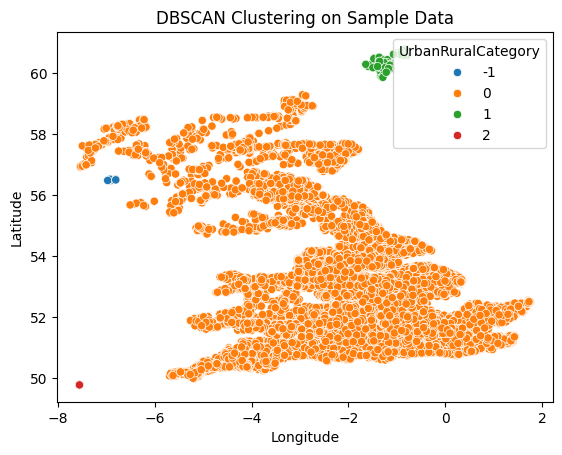

In [236]:
# Calculate stop density (number of stops in small geographic grids)
stop_density = stops_data.groupby(['Longitude', 'Latitude']).size().reset_index(name='StopDensity')
stops_data = stops_data.merge(stop_density, on=['Longitude', 'Latitude'], how='left')

# Scale features for K-Means clustering
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(stops_data[['Longitude', 'Latitude', 'StopDensity']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=1)
stops_data['UrbanRuralCategory'] = kmeans.fit_predict(scaled_features)

# Map clusters to urban/rural labels
stops_data['UrbanRuralCategory'] = stops_data['UrbanRuralCategory'].map({0: 'Rural', 1: 'Urban'})

# Save the processed file
stops_data.to_csv('data/processed/q1_processed_stops.csv', index=False)
print("Q1 processed file with improved categorization saved successfully.")

**Q1 : 2nd iteration - Categorisation of Urban and Rural Stops** - FAILED ATTEMPT

In [58]:

# Step 1: Apply DBSCAN clustering with adjusted parameters
#eps_value = 0.05  # Reduce eps further to make the distance sensitivity more granular
#min_samples_value = 30  # Slightly higher min_samples to allow only significant clusters

# Apply DBSCAN with the new parameters
#dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value, metric='haversine', n_jobs=-1)

# Ensure we are modifying the original DataFrame by using .loc[]
#london_stops_data.loc[:, 'Cluster'] = dbscan.fit_predict(np.radians(london_stops_data[['Latitude', 'Longitude']]))

# Group by clusters to determine the size of each cluster
#urban_clusters = london_stops_data.groupby('Cluster').size().sort_values(ascending=False)

# Manually assign 'Urban' to large clusters and 'Rural' to smaller clusters
#urban_clusters_map = {cluster: 'Urban' if size > 5 else 'Rural' for cluster, size in urban_clusters.items()}

# Use .loc[] to assign the UrbanRuralCategory to the appropriate clusters
#london_stops_data.loc[:, 'UrbanRuralCategory'] = london_stops_data['Cluster'].map(urban_clusters_map)

# Compute centroids for each cluster (cluster center)
#centroids = london_stops_data.groupby('Cluster')[['Latitude', 'Longitude']].mean().reset_index()
#centroids.rename(columns={'Latitude': 'Centroid_Latitude', 'Longitude': 'Centroid_Longitude'}, inplace=True)

# Check if centroids DataFrame is created correctly
#print(centroids.head())  # Debug: Check the first few rows of centroids

# Merge centroids with original data to match cluster with its centroid
# Avoid duplicate column names by renaming columns in centroids
#london_stops_data = london_stops_data.merge(centroids, on='Cluster', how='left', suffixes=('', '_centroid'))

# Check if the merge was successful
#print(london_stops_data[['Cluster', 'Centroid_Latitude_centroid', 'Centroid_Longitude_centroid']].head())  # Debug: Check merge result

# Compute nearest neighbor distance to the cluster center
#def haversine_distance(lat1, lon1, lat2, lon2):
 #   return geodesic((lat1, lon1), (lat2, lon2)).meters

# Calculate the distance from each stop to its corresponding cluster centroid
#london_stops_data['DistanceToCentroid'] = london_stops_data.apply(
 #   lambda row: haversine_distance(row['Latitude'], row['Longitude'], row['Centroid_Latitude_centroid'], row['Centroid_Longitude_centroid']),
  #  axis=1
#)

# Adjust the threshold for urban vs rural based on the distribution of distances
#urban_distance_threshold = london_stops_data['DistanceToCentroid'].quantile(0.5)  # Or 0.75 for stricter definition of "Urban"

# Recalculate Urban vs Rural categories
#london_stops_data['UrbanRuralCategory'] = london_stops_data['DistanceToCentroid'].apply(
 #   lambda x: 'Urban' if x <= urban_distance_threshold else 'Rural'
#)

# Check the distribution again
#print(london_stops_data['UrbanRuralCategory'].value_counts())

# Saving the processed London data with updated clustering
#london_stops_data.to_csv('../data/processed/london_stops_with_clusters.csv', index=False)
#london_stops_data.to_parquet('../data/processed/london_stops_with_clusters.parquet')
#print("London stops with updated clustering saved successfully.")


   Cluster  Centroid_Latitude  Centroid_Longitude
0        0          51.530586           -0.148479
   Cluster  Centroid_Latitude_centroid  Centroid_Longitude_centroid
0        0                   51.530586                    -0.148479
1        0                   51.530586                    -0.148479
2        0                   51.530586                    -0.148479
3        0                   51.530586                    -0.148479
4        0                   51.530586                    -0.148479
Urban    10058
Rural    10057
Name: UrbanRuralCategory, dtype: int64


ValueError: Duplicate column names found: ['ATCOCode', 'NaptanCode', 'CommonName', 'NptgLocalityCode', 'LocalityName', 'LocalityCentre', 'Easting', 'Northing', 'Longitude', 'Latitude', 'StopType', 'BusStopType', 'TimingStatus', 'AdministrativeAreaCode', 'CreationDateTime', 'ModificationDateTime', 'RevisionNumber', 'Modification', 'Status', 'Cluster', 'UrbanRuralCategory', 'Centroid_Latitude_x', 'Centroid_Longitude_x', 'DistanceToCentroid', 'Centroid_Latitude_y', 'Centroid_Longitude_y', 'Centroid_Latitude_x', 'Centroid_Longitude_x', 'Centroid_Latitude_y', 'Centroid_Longitude_y', 'Centroid_Latitude', 'Centroid_Longitude', 'Centroid_Latitude_centroid', 'Centroid_Longitude_centroid']

Q2. **Locality Groupings**
- The data is grouped by LocalityName and LocalityCentre for the sake of aggregation and visualisation in terms of maintenance activities.

In [148]:
# Create a copy of the Greater London dataset for processing
stops_data_q2 = london_stops_data.copy()

# Grouping by LocalityName and LocalityCentre
locality_grouped = stops_data_q2.groupby(['LocalityName', 'LocalityCentre']).agg({
    'StopType': 'count',  # Count of Stop Types
    'ModificationDateTime': 'max',  # Most recent modification
    'RevisionNumber': 'sum'  # Total revisions
}).reset_index()

# Renaming the columns for clarity
locality_grouped.rename(columns={
    'StopType': 'StopCount', 
    'ModificationDateTime': 'MostRecentModification', 
    'RevisionNumber': 'TotalRevisions'
}, inplace=True)

# Saving the processed file
locality_grouped.to_csv('../data/processed/q2_processed_london_stops.csv', index=False)
locality_grouped.to_parquet('../data/processed/q2_processed_london_stops.parquet')

print("Q2 processed file for locality grouping in Greater London saved successfully.")


Q2 processed file for locality grouping in Greater London saved successfully.


Q3. **Density Calculation by Administrative Area Code**
- Here I am calculating the stop density per AdministrativeAreaCode, which is a larger size compared to Q1 grid area density. 

In [ ]:
# Create a copy of the Greater London dataset for processing
stops_data_q3 = london_stops_data.copy()

# Aggregating localities by AdministrativeAreaCode (to simplify linkage)
density_data = stops_data_q3.groupby('AdministrativeAreaCode').agg(
    StopCount=('LocalityName', 'count')  # Count the number of stops within each area
).reset_index()

# Calculating the density (stops per square kilometer)
# Using the bounding box defined by Longitude and Latitude for Greater London
longitude_range = stops_data_q3['Longitude'].max() - stops_data_q3['Longitude'].min()
latitude_range = stops_data_q3['Latitude'].max() - stops_data_q3['Latitude'].min()
bounding_box_area = longitude_range * latitude_range  # Area of the bounding box

# calculate the density for each AdministrativeAreaCode
density_data['Density'] = density_data['StopCount'] / bounding_box_area

# Saving the processed file
density_data.to_csv('../data/processed/q3_processed_london_stops.csv', index=False)
density_data.to_parquet('../data/processed/q3_processed_london_stops.parquet', index=False)

print("Q3 processed file with density calculation for Greater London saved successfully.")

Q4. **The Extraction of Temporal Features**
- **Extracting** features from "CreationDateTime" and "ModificationDateTime" for temporal analysis

In [157]:
# Assuming `stops_data` is the dataset containing 'CreationDateTime' and 'ModificationDateTime'
stops_data_q4 = stops_data.copy()

# Ensure CreationDateTime and ModificationDateTime are in datetime format
stops_data_q4['CreationDateTime'] = pd.to_datetime(stops_data_q4['CreationDateTime'], errors='coerce')
stops_data_q4['ModificationDateTime'] = pd.to_datetime(stops_data_q4['ModificationDateTime'], errors='coerce')

# Extracting the temporal features
stops_data_q4['TimeSinceCreation'] = (pd.Timestamp.now(tz='UTC') - stops_data_q4['CreationDateTime']).dt.days
stops_data_q4['TimeSinceModification'] = (pd.Timestamp.now(tz='UTC') - stops_data_q4['ModificationDateTime']).dt.days

# Selecting relevant features for further analysis
temporal_features = stops_data_q4[['ATCOCode', 'TimeSinceCreation', 'TimeSinceModification']]

# Saving the processed file with temporal features
temporal_features.to_csv('../data/processed/q4_processed_stops.csv', index=False)
temporal_features.to_parquet('../data/processed/q4_processed_stops.parquet', index=False)

print("Q4 processed file with temporal features saved successfully.")

Q4 processed file with temporal features saved successfully.


Index(['AdministrativeAreaCode', 'StopCount', 'Density'], dtype='object')
